# Refine the 4 NREL5MW turbine domain

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import shutil
import yaml

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
#rundir = '/lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/windfarm/test/exawind-cases/16_turb_abl_fsi/run_refinedomain'
#originalinput = 'nrel5mw_amr.inp'
rundir = '/ccs/proj/cfd162/lcheung/exawind-benchmarks/amr-wind/actuator_line/NREL5MW_ALM_BD/input_files'
originalinput = 'NREL5MW_BR.inp'
outputfile    = 'nrel5mw_amr_4turbine.inp'

In [4]:
# Load the starting point
curdir=os.getcwd()

# This assumes that rundir was already set up with setup.sh (see https://github.com/Exawind/exawind-cases/blob/main/16_turb_abl_fsi/setup.sh)
os.chdir(rundir)
case.loadAMRWindInput(originalinput)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('io.KE_int', '-1'),
             ('ABL.enable_hybrid_rl_mode', 'true'),
             ('amr.max_grid_size', '128'),
             ('amr.blocking_factor', '32'),
             ('nodal_proj.max_coarsening_level', '0'),
             ('nodal_proj.num_pre_smooth', '10'),
             ('nodal_proj.num_post_smooth', '10'),
             ('nodal_proj.bottom_rtol', '1.0e-9'),
             ('nodal_proj.bottom_atol', '1.0e-12'),
             ('mac_proj.verbose', '0'),
             ('mac_proj.max_coarsening_level', '0'),
             ('mac_proj.do_nsolve', 'true'),
             ('mac_proj.bottom_verbose', '0'),
             ('mac_proj.bottom_rtol', '1.0e-11'),
             ('mac_proj.bottom_atol', '1.0e-12'),
             ('mac_proj.num_pre_smooth', '10'),
             ('mac_proj.num_post_smooth', '10'),
             ('diffusion.verbose', '0'),
             ('diffusion.do_agglomeration', 'false'),
             ('diffusion.do_nsolve', 'true'),
             ('velocity_diffusion.verbose', '

## Set the turbine locations

In [5]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

In [6]:
# Turbine spacing
turb_LatSpacing  = 8   # lateral spacing, diameters
turb_LongSpacing = 4   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':2, 'rowoffset':0},
               {'Nturb':2, 'rowoffset':0},
               #{'Nturb':5, 'rowoffset':1.5},
               #{'Nturb':5, 'rowoffset':4.5},
               #{'Nturb':5, 'rowoffset':1.5},
              ]

farmturb_orig    = [1800, 1800]

In [7]:
# Define some properties
rotorD = 126           # Rotor diameter
WS     = 10            # Wind speed, m/s
WDir   = 240           # Wind direction, degrees

# Farm properties
farm_rotate      = 30 #+26.6  

# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

# Recenter the farm to be at the origin
farmturb_0 = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_0 for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])
farmturb_xy = np.array([x+farmturb_orig for x in farmturb_xy])

Total turbines = 4


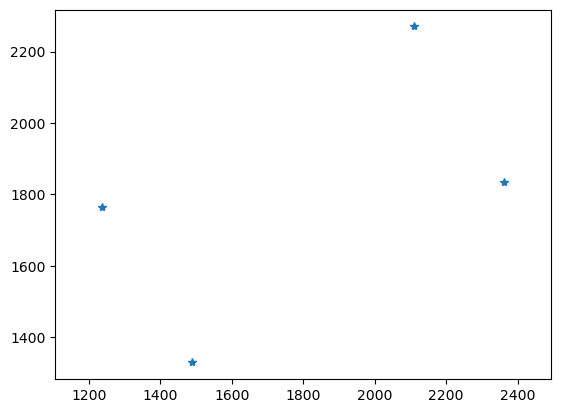

In [8]:
# Test plot
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');

In [9]:
turbinetype = case.get_default_turbinetypedict()

turbinetype['turbinetype_name'] = 'NREL5MW_junk'
turbinetype['Actuator_type']    = 'UniformCtDisk'
turbinetype['Actuator_rotor_diameter']     = 126.0
turbinetype['Actuator_hub_height']         = 90.0
turbinetype['Actuator_epsilon']            = [2.5]
turbinetype['Actuator_output_frequency']   = 1
turbinetype['Actuator_diameters_to_sample']= 5.0 
turbinetype['Actuator_num_points_r']       = 20
turbinetype['Actuator_num_points_t']       = 3
turbinetype['Actuator_thrust_coeff']       = 0.2
case.add_populatefromdict('listboxturbinetype', turbinetype)

In [10]:
# Build the CSV input file of turbine layouts for amrwind-frontend

options=""

turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="turb%i, %f, %f, NREL5MW_junk, %f, ,%s\n"
for iturb, xy in enumerate(farmturb_xy ):
    turboptions  = options
    # uncomment this line for AWC
    #if iturb < 3:   turboptions += AWCoptions
    turbinescsv += rowformat%(iturb, xy[0], xy[1], WDir, turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)
print(turbinescsv)

# Save to a file
file = open(curdir+'/turbine_locations.csv', "w")
file.write(turbinescsv)
file.close()


# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
turb0, 1489.523196, 1329.761598, NREL5MW_junk, 240.000000, ,
turb1, 2362.476804, 1833.761598, NREL5MW_junk, 240.000000, ,
turb2, 1237.523196, 1766.238402, NREL5MW_junk, 240.000000, ,
turb3, 2110.476804, 2270.238402, NREL5MW_junk, 240.000000, ,



In [11]:
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_createnewdomain', False)

case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['turb0', 'turb1', 'turb2', 'turb3']


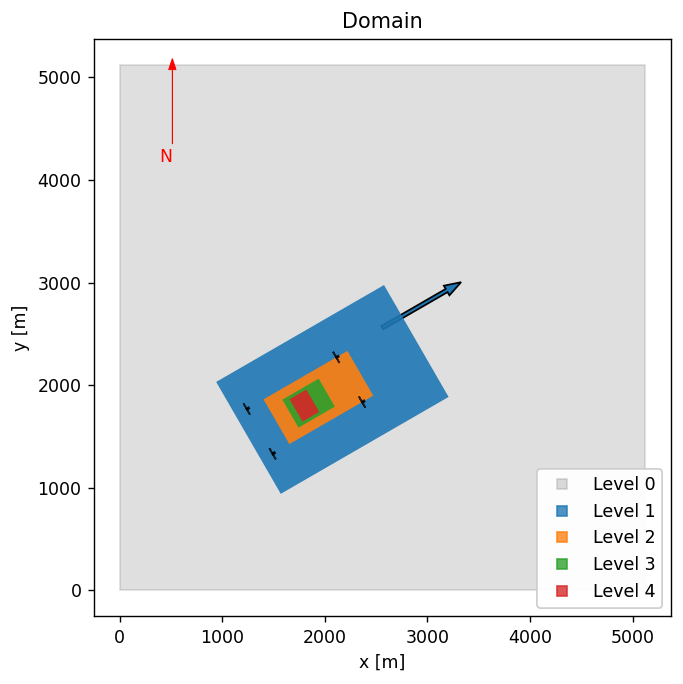

In [12]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)


In [13]:
case.estimateMeshSize()

Refinement T0_level_0_zone: level 1: 6601240 cells
Refinement T0_level_1_zone: level 2: 8641624 cells
Refinement T0_level_2_zone: level 3: 14562737 cells
Refinement T0_level_3_zone: level 4: 36870930 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
       1      6601240                5.0 x 5.0 x 5.0
       2      8641624                2.5 x 2.5 x 2.5
       3     14562737             1.25 x 1.25 x 1.25
       4     36870930          0.625 x 0.625 x 0.625
  TOTAL:    117008179


In [14]:
## Add refinement zones
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     2160,     2160,       2160,    90,   200,   center:specified units:meter orientation:x centerx:2560 centery:2560 centerz:90 name:level1
1,     800,      2800,       750,    90,   200,   center:specified units:meter centerx:1800 centery:1800 centerz:90 name:level2
#2,     1.25,     8.0,        1.25,  0.75,   1.0, 
2,     1.25,     12.0,       1.5,  0.75,   1.0, 
3,     0.5,      0.5,        1.00,  0.75,   0.75, 
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)
case.refine_createAllZones()

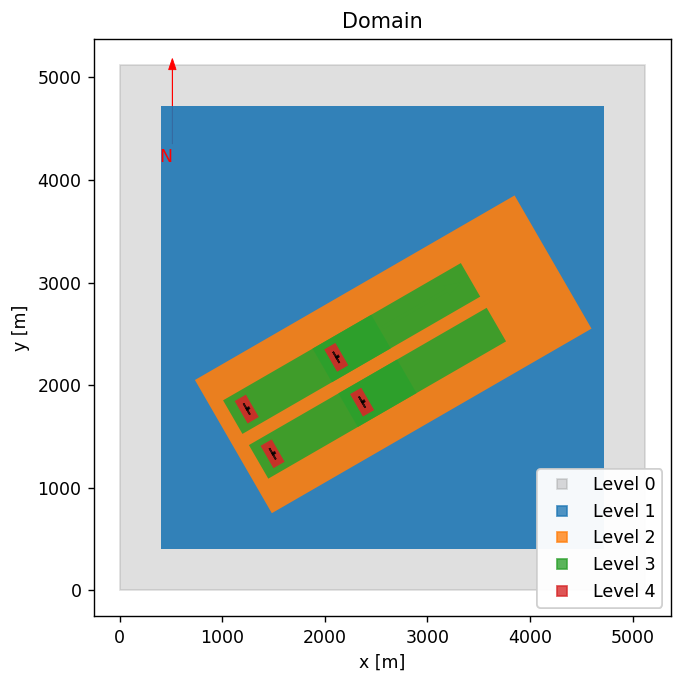

In [15]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)

In [16]:
case.estimateMeshSize()

Refinement level1: level 1: 43296768 cells
Refinement level2: level 2: 100224000 cells
Refinement turb0_level_2_zone: level 3: 71245391 cells
Refinement turb1_level_2_zone: level 3: 71245391 cells
Refinement turb2_level_2_zone: level 3: 71245391 cells
Refinement turb3_level_2_zone: level 3: 71245391 cells
Refinement turb0_level_3_zone: level 4: 24580620 cells
Refinement turb1_level_3_zone: level 4: 24580620 cells
Refinement turb2_level_3_zone: level 4: 24580620 cells
Refinement turb3_level_3_zone: level 4: 24580620 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
       1     43296768                5.0 x 5.0 x 5.0
       2    100224000                2.5 x 2.5 x 2.5
       3    284981564             1.25 x 1.25 x 1.25
       4     98322480          0.625 x 0.625 x 0.625
  TOTAL:    577156460


## Add some sampling planes

In [17]:
# First delete everything that already exists
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [18]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:25"
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
turbdomain,hubheight,  8,        8,         2,       0,     126,     11, 11, units:meter usedx:16 outputto:turbdomain_ orientation:nacdir center:farm wholedomain:1  {outputoptions} noffsets:1

rotorplaneUP,  rotorplane, 4,     0,       2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneUP_  orientation:nacdir {outputoptions} noffsets:4
rotorplaneDN,  rotorplane, 0,     10,      2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneDN_  orientation:nacdir {outputoptions} noffsets:10
nearwake,    rotorplane, 0,       2,      2,    0.7,      1,  11, 11,            usedx:0.05 outputto:nearwake_      orientation:nacdir {outputoptions} noffsets:4
turbsw,      streamwise, 4,       10,      0,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:turbsw_        orientation:nacdir {outputoptions} noffsets:0
turbhh,      hubheight,  4,       10,      2,       0,    0,   11, 11,           usedx:0.05 outputto:turbhh_        orientation:nacdir {outputoptions} noffsets:0
turb027,     hubheight,  4,       10,      2,    0.50,    0,   11, 11,           usedx:0.05 outputto:turb027_       orientation:nacdir {outputoptions} noffsets:0
turb153,     hubheight,  4,       10,      2,    -0.50,  0.50, 11, 11,           usedx:0.05 outputto:turb153_       orientation:nacdir {outputoptions} noffsets:0
turb216,     hubheight,  4,       10,      2,      -1,    1,   11, 11,           usedx:0.05 outputto:turb216_       orientation:nacdir {outputoptions} noffsets:0
sideplane1,  streamwise, 4,       10,      2,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:sideplane1_    orientation:nacdir {outputoptions} noffsets:1
sideplane2,  streamwise, 4,       10,     -2,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:sideplane2_    orientation:nacdir {outputoptions} noffsets:1
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [19]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_turbdomain', 'turb0_rotorplaneUP', 'turb1_rotorplaneUP', 'turb2_rotorplaneUP', 'turb3_rotorplaneUP', 'turb0_rotorplaneDN', 'turb1_rotorplaneDN', 'turb2_rotorplaneDN', 'turb3_rotorplaneDN', 'turb0_nearwake', 'turb1_nearwake', 'turb2_nearwake', 'turb3_nearwake', 'turb0_turbsw', 'turb1_turbsw', 'turb2_turbsw', 'turb3_turbsw', 'turb0_turbhh', 'turb1_turbhh', 'turb2_turbhh', 'turb3_turbhh', 'turb0_turb027', 'turb1_turb027', 'turb2_turb027', 'turb3_turb027', 'turb0_turb153', 'turb1_turb153', 'turb2_turb153', 'turb3_turb153', 'turb0_turb216', 'turb1_turb216', 'turb2_turb216', 'turb3_turb216', 'turb0_sideplane1', 'turb1_sideplane1', 'turb2_sideplane1', 'turb3_sideplane1', 'turb0_sideplane2', 'turb1_sideplane2', 'turb2_sideplane2', 'turb3_sideplane2']


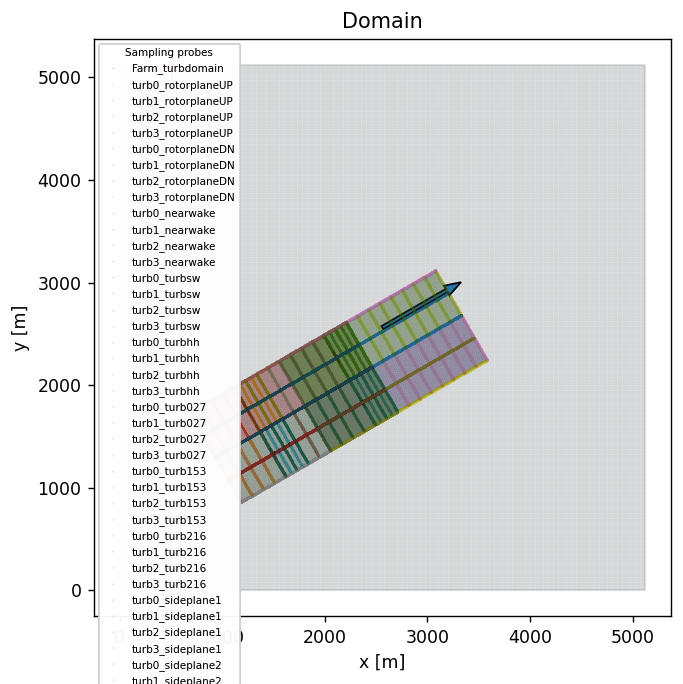

In [20]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend']= "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper left', 'markerscale':10}"
case.plotDomain(ax=ax)

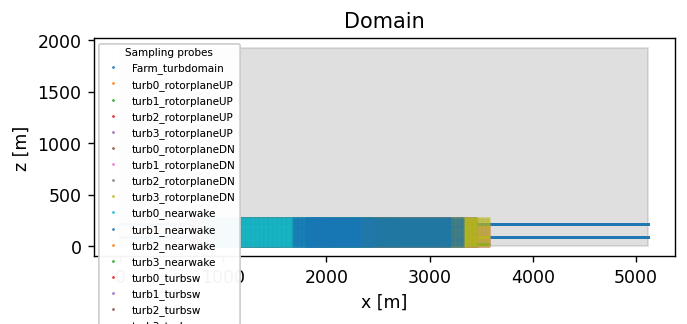

In [21]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None'}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ'
case.plotDomain(ax=ax)

In [22]:
# Add derived fields
case.setAMRWindInput('io.derived_outputs', 'q_criterion mag_vorticity')
case.setAMRWindInput('time.plot_interval', 1000)

In [23]:
# Delete unneeded keys
case.extradictparams.pop('io.KE_int', None)
case.extradictparams.pop('mac_proj.max_coarsening_level', None)
case.extradictparams.pop('nodal_proj.max_coarsening_level', None)

'0'

In [24]:
## Create a version without turbines
case.removeturbines()
print(case.writeAMRWindInput(''))

os.chdir(curdir)
inputfile=case.writeAMRWindInput(outputfile)
#print(inputfile)

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.003443526170799   # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   